In [40]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re

from ydata_profiling import ProfileReport

import sys

sys.path.append('../src')
from utils import getExperimentConfig, translate_model_name

# Get global experiment settings
config = getExperimentConfig()
folders = config['folders']

# Performance analysis

In [53]:
raw_runs_df = pd.read_csv(f"{folders['data_dir']}runs2.csv")
raw_runs_df.head(3)

,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,C,activation,algorithm,alpha,average,batch_size,beta_1,beta_2,bootstrap,break_ties,cache_size,ccp_alpha,class_weight,coef0,criterion,decision_function_shape,degree,dual,early_stopping,epsilon,eta0,fit_intercept,gamma,hidden_layer_sizes,init,intercept_scaling,kernel,l1_ratio,leaf_size,learning_rate,learning_rate_init,loss,max_depth,max_features,max_fun,max_iter,max_leaf_nodes,max_samples,metric,metric_params,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,momentum,multi_class,n_estimators,n_iter_no_change,n_jobs,n_neighbors,nesterovs_momentum,oob_score,p,penalty,power_t,priors,probability,random_state,shrinking,shuffle,solver,subsample,tol,validation_fraction,var_smoothing,verbose,warm_start,weights,AUC,Accuracy,F1-score,Kappa,MCC,val_Accuracy,val_F1-score,Dataset ID,Dataset Type,model,Run ID.1,USI,model run id,model run name
0,2023-04-12 13:41:16,NaN,7f981a2534ae47ae80ccac7f581cc7c5,SD0Q1_1-Multilayer Perceptron,LOCAL,C:\Users\flore\miniconda3\envs\master\lib\site...,flore,RUNNING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SD0Q1_1,synthetic,mlp,7f981a2534ae47ae80ccac7f581cc7c5,b2ba,NaN,NaN
1,2023-04-12 13:37:33,3.7min,65d8174c4ad44f44a51fd49c330d5234,SD0Q1_1-SVM-RBF,LOCAL,C:\Users\flore\miniconda3\envs\master\lib\site...,flore,FINISHED,22.252834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,200.0,NaN,None,0.0,NaN,ovr,3.0,NaN,NaN,NaN,NaN,NaN,auto,NaN,NaN,NaN,rbf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2969.0,True,NaN,NaN,NaN,0.001,NaN,NaN,False,NaN,NaN,0.5,0.348958,0.258687,0.000000,0.000000,0.6270,0.7605,SD0Q1_1,synthetic,rbfsvm,65d8174c4ad44f44a51fd49c330d5234,b2ba,NaN,NaN
2,2023-04-12 13:33:50,3.7min,f16f4edecca14e3584a1d0dc4c6b7096,SD0Q1_1-SVM,LOCAL,C:\Users\flore\miniconda3\envs\master\lib\site...,flore,FINISHED,NaN,NaN,NaN,0.000003,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,False,0.1,0.058727,True,NaN,NaN,NaN,NaN,NaN,0.12828281334905173,NaN,constant,NaN,hinge,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,-1,NaN,NaN,NaN,NaN,l2,0.5,NaN,NaN,2969.0,NaN,True,NaN,NaN,0.001,0.1,NaN,0,False,NaN,NaN,0.641927,0.397781,-0.013552,-0.042271,0.6255,0.7643,SD0Q1_1,synthetic,svm,f16f4edecca14e3584a1d0dc4c6b7096,b2ba,NaN,NaN


In [54]:
# The columns of data that will be used to analyze the results
cols_to_keep = [
    'Run ID',
    'Name',
    'Accuracy',
    'F1-score',
    'Kappa',
    'MCC',
    'AUC',
    'val_Accuracy',
    'val_F1-score',
    'Dataset ID',
    'Dataset Type',
    'model'
]

cols_to_drop = [col for col in raw_runs_df.columns if col not in cols_to_keep]
print(cols_to_drop)
runs_df = raw_runs_df.drop(columns=cols_to_drop)

# remove rows with 'models' in their name, they are a "header" row that are not needed here
runs_df=runs_df[~runs_df['Name'].str.contains('models')]
runs_df.head()

['Start Time', 'Duration', 'Source Type', 'Source Name', 'User', 'Status', 'C', 'activation', 'algorithm', 'alpha', 'average', 'batch_size', 'beta_1', 'beta_2', 'bootstrap', 'break_ties', 'cache_size', 'ccp_alpha', 'class_weight', 'coef0', 'criterion', 'decision_function_shape', 'degree', 'dual', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'gamma', 'hidden_layer_sizes', 'init', 'intercept_scaling', 'kernel', 'l1_ratio', 'leaf_size', 'learning_rate', 'learning_rate_init', 'loss', 'max_depth', 'max_features', 'max_fun', 'max_iter', 'max_leaf_nodes', 'max_samples', 'metric', 'metric_params', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'momentum', 'multi_class', 'n_estimators', 'n_iter_no_change', 'n_jobs', 'n_neighbors', 'nesterovs_momentum', 'oob_score', 'p', 'penalty', 'power_t', 'priors', 'probability', 'random_state', 'shrinking', 'shuffle', 'solver', 'subsample', 'tol', 'validation_fraction', 'var_smoothing', 'verbose', 'war

,Run ID,Name,AUC,Accuracy,F1-score,Kappa,MCC,val_Accuracy,val_F1-score,Dataset ID,Dataset Type,model
0,7f981a2534ae47ae80ccac7f581cc7c5,SD0Q1_1-Multilayer Perceptron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SD0Q1_1,synthetic,mlp
1,65d8174c4ad44f44a51fd49c330d5234,SD0Q1_1-SVM-RBF,0.500000,0.348958,0.258687,0.000000,0.000000,0.6270,0.7605,SD0Q1_1,synthetic,rbfsvm
2,f16f4edecca14e3584a1d0dc4c6b7096,SD0Q1_1-SVM,NaN,0.641927,0.397781,-0.013552,-0.042271,0.6255,0.7643,SD0Q1_1,synthetic,svm
3,da4d70b5e3594c00977a9395228bb57b,SD0Q1_1-Naive Bayes,0.500000,0.651042,0.394322,0.000000,0.000000,0.6206,0.7620,SD0Q1_1,synthetic,nb
4,2acbf2554d4b40748a4e740b0920bc18,SD0Q1_1-K-Nearest Neighbor,0.492325,0.649740,0.393844,-0.002601,-0.026435,0.6367,0.7603,SD0Q1_1,synthetic,knn


In [55]:
# Filter out rows with 'Original' in the 'Name' column
df = runs_df[~runs_df['Name'].str.contains('Original')]

df['Dataset ID'] =  df['Dataset ID'].str.split('_').str[0]

# Group by the starting substring and calculate the mean of specified columns
mean_columns = ['F1-score', 'Kappa', 'AUC', 'Accuracy', 'MCC', 'val_Accuracy', 'val_F1-score']
grouped = df.groupby(['Dataset ID', 'model'])[mean_columns].mean()

# Reset index to convert indices to columns
grouped = grouped.reset_index()

# Remove the 'Run ID' column
grouped = grouped.drop(['Run ID'], axis=1, errors='ignore')

grouped

,Dataset ID,model,F1-score,Kappa,AUC,Accuracy,MCC,val_Accuracy,val_F1-score
0,D0,gbc,0.615400,0.450100,0.826500,0.763700,0.460400,NaN,NaN
1,D0,knn,0.594300,0.428200,0.809800,0.757200,0.440200,NaN,NaN
2,D0,lr,0.618000,0.454900,0.826600,0.765500,0.464700,NaN,NaN
3,D0,mlp,0.637500,0.461000,0.828900,0.760600,0.466300,NaN,NaN
4,D0,nb,0.618800,0.435500,0.808200,0.750700,0.440100,NaN,NaN
5,D0,rbfsvm,0.590100,0.391100,0.768000,0.729600,0.396900,NaN,NaN
6,D0,rf,0.649900,0.485000,0.827600,0.773500,0.491300,NaN,NaN
7,D0,svm,0.615300,0.450800,0.000000,0.763800,0.462400,NaN,NaN
8,SD0Q1,gbc,0.438643,-0.105948,0.528817,0.457031,-0.109326,0.66950,0.78560
9,SD0Q1,knn,0.388978,0.022359,0.496162,0.532552,0.033044,0.65630,0.77400


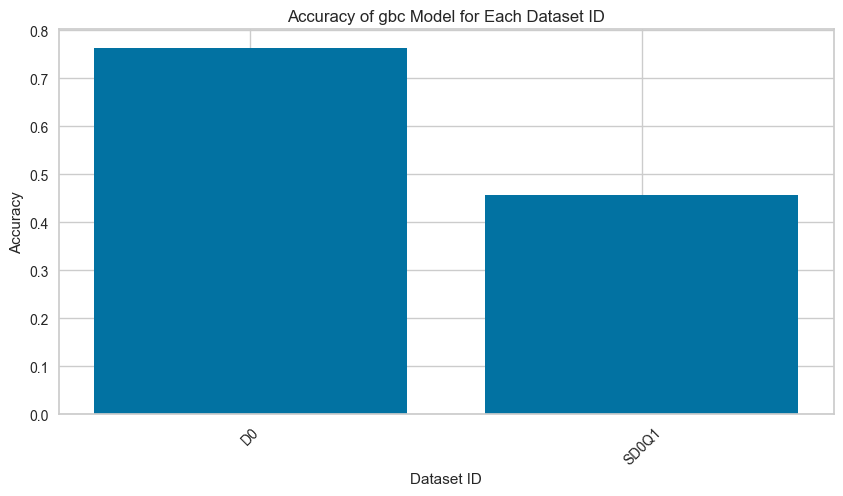

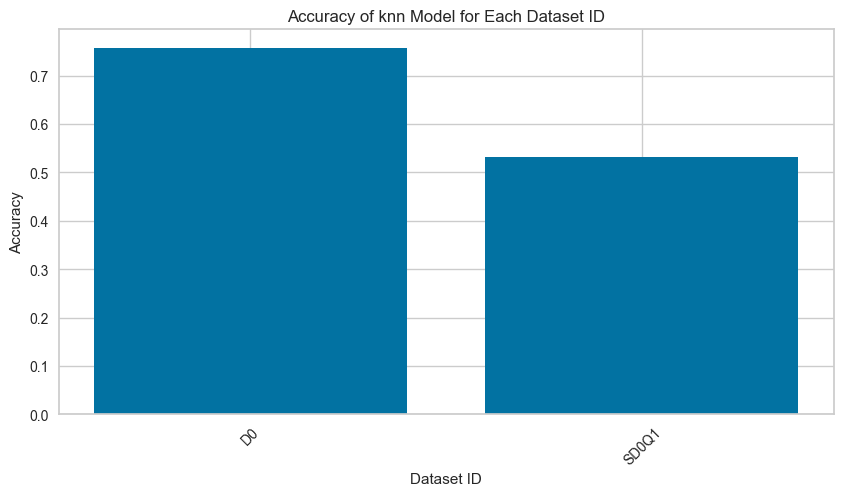

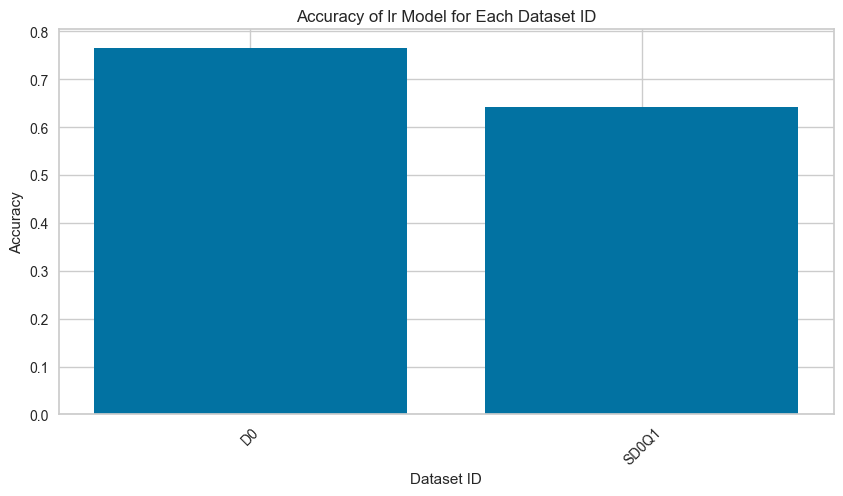

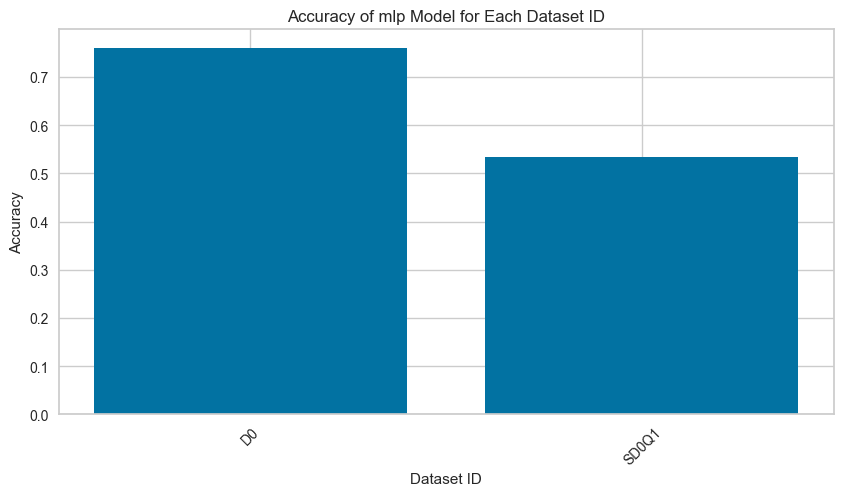

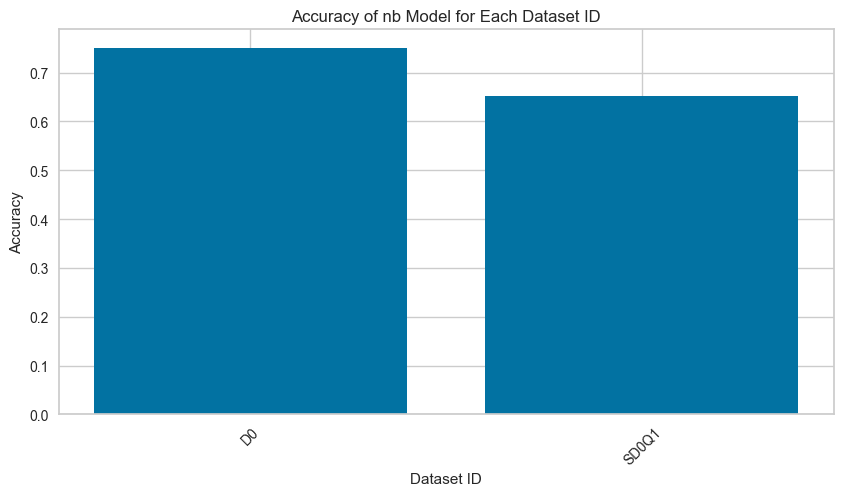

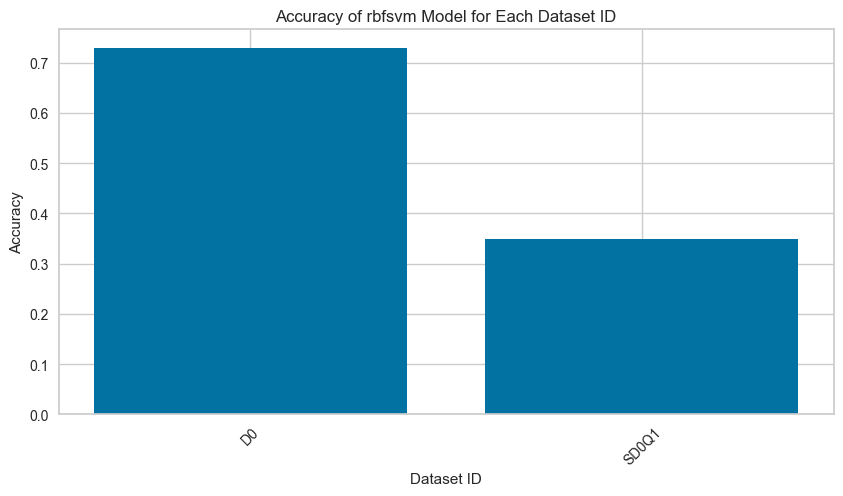

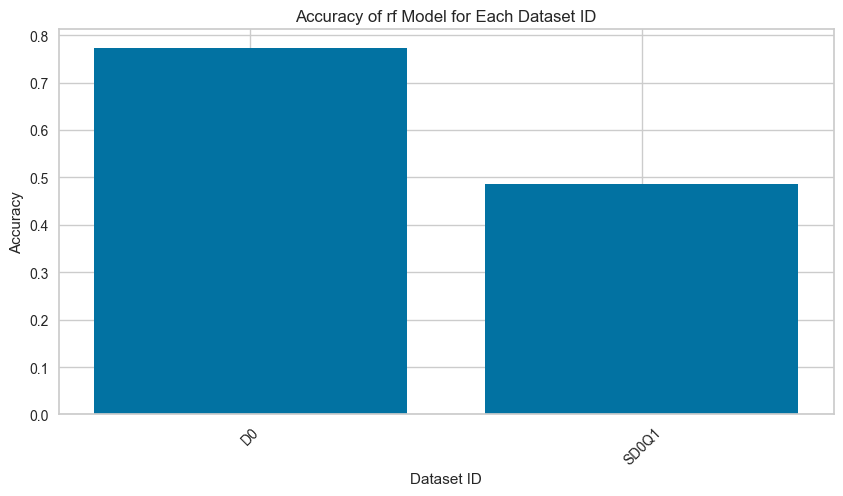

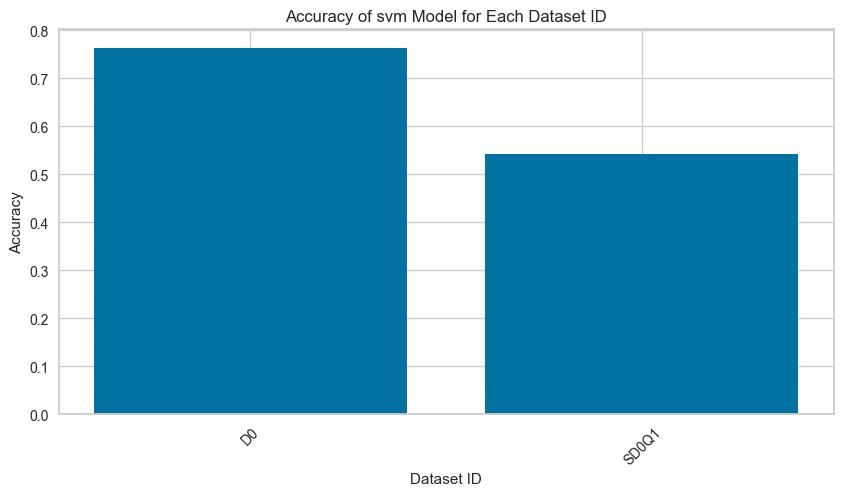

In [56]:
data = grouped
# Find unique models
models = data['model'].unique()

# Loop through the models and create a bar plot for each
for model in models:
    # Filter the data for the current model
    model_data = data[data['model'] == model]

    # Create a bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(model_data['Dataset ID'], model_data['Accuracy'])
    plt.xlabel('Dataset ID')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy of {model} Model for Each Dataset ID')
    plt.xticks(rotation=45)
    plt.show()

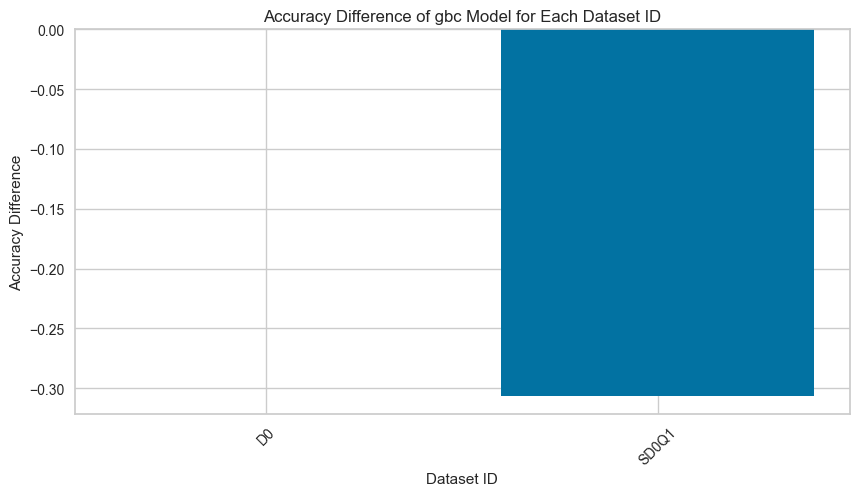

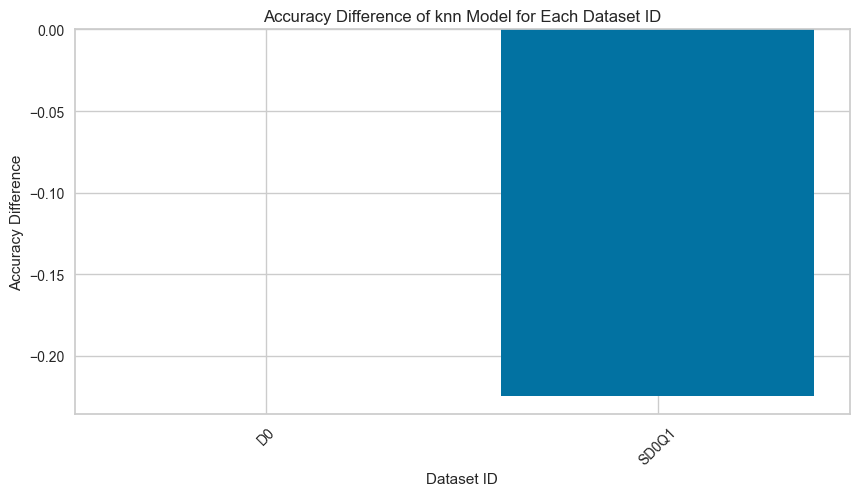

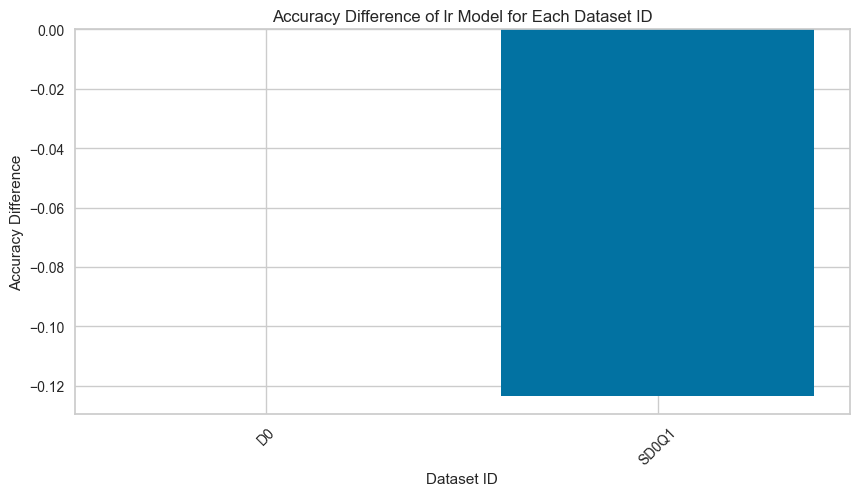

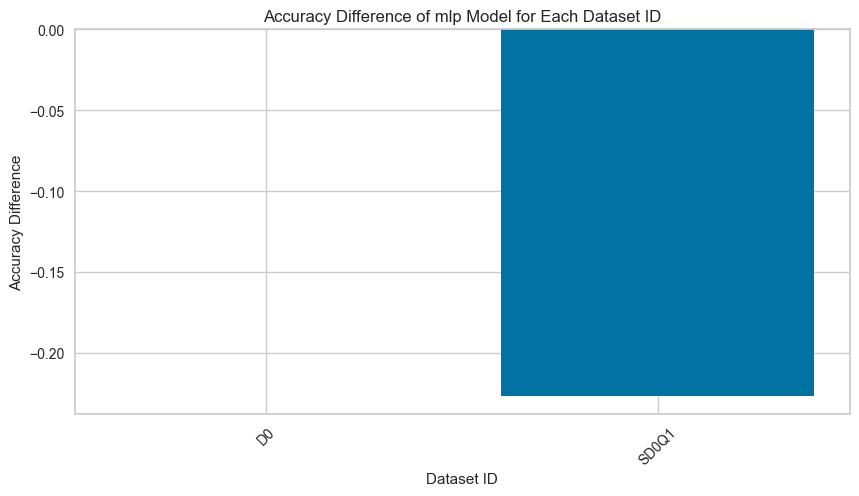

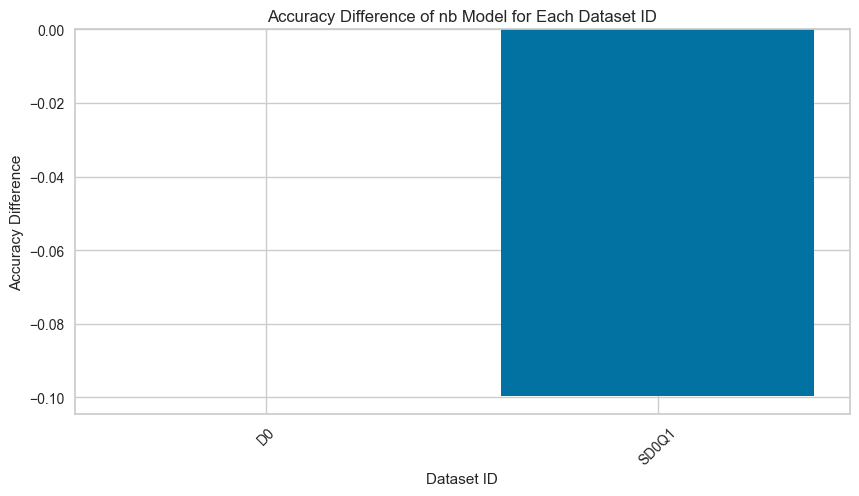

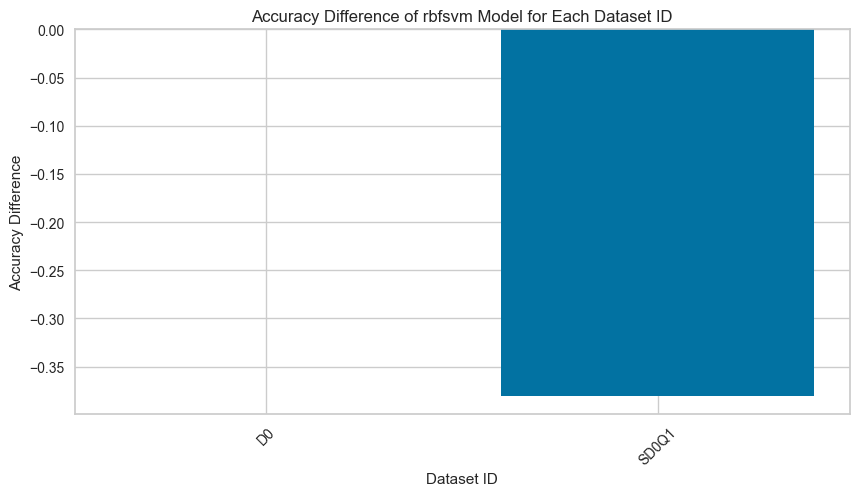

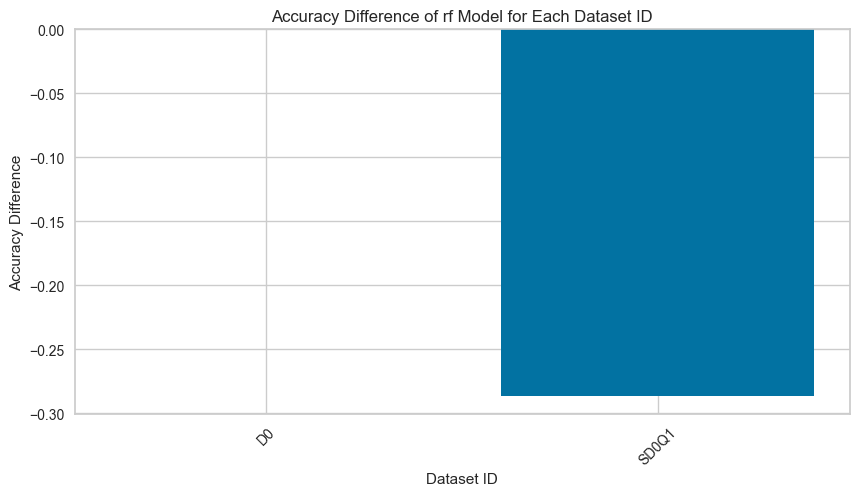

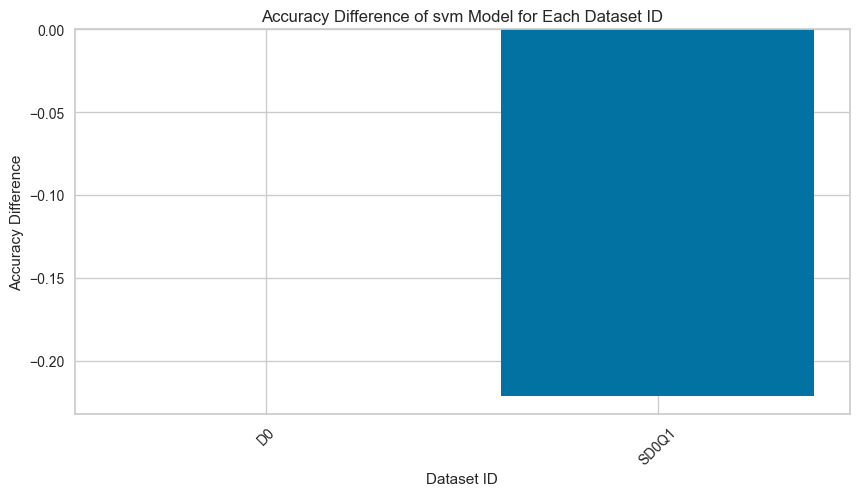

In [57]:
data = grouped
# Find unique models
models = data['model'].unique()

# Find 'Accuracy' values for rows with 'Dataset ID' containing only 'D' and a number
d_accuracies = data[data['Dataset ID'].apply(lambda x: bool(re.match(r'^D\d+$', x)))][['model', 'Accuracy']]

# Loop through the models and create a bar plot for each
for model in models:
    # Filter the data for the current model
    model_data = data[data['model'] == model]

    # Find the corresponding 'D' accuracy for the current model
    d_accuracy = d_accuracies[d_accuracies['model'] == model]['Accuracy'].values[0]

    # Compute the difference between 'Accuracy' and the corresponding 'D' accuracy
    model_data['accuracy_diff'] = model_data['Accuracy'] - d_accuracy

    # Create a bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(model_data['Dataset ID'], model_data['accuracy_diff'])
    plt.xlabel('Dataset ID')
    plt.ylabel('Accuracy Difference')
    plt.title(f'Accuracy Difference of {model} Model for Each Dataset ID')
    plt.xticks(rotation=45)
    plt.show()

ValueError: The number of FixedLocator locations (16), usually from a call to set_ticks, does not match the number of ticklabels (8).

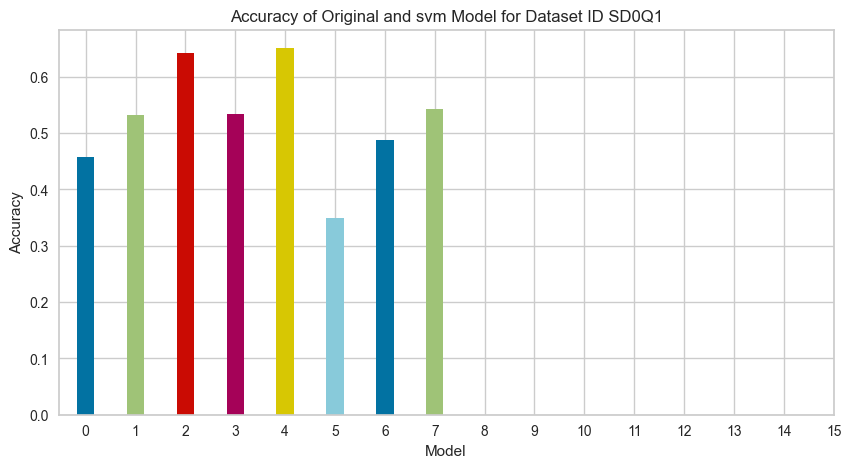

In [58]:
# Find unique models
models = data['model'].unique()

# Find unique Dataset IDs excluding those containing only 'D' and a number
dataset_ids = data[~data['Dataset ID'].apply(lambda x: bool(re.match(r'^D\d+$', x)))]['Dataset ID'].unique()

# Loop through the Dataset IDs
for dataset_id in dataset_ids:
    # Create a DataFrame to store the data for the split bars
    split_bar_data = pd.DataFrame()

    # Loop through the models
    for model in models:
        # Filter the data for the current model and dataset_id
        model_data = data[(data['model'] == model) & (data['Dataset ID'] == dataset_id)]

        # Find the corresponding original model data
        original_data = data[data['model'].apply(lambda x: bool(re.match(rf'^{dataset_id}_\d+-Original{translate_model_name(model)}$', x))) & (data['Dataset ID'] == dataset_id)]

        # Add the original data to the split_bar_data
        split_bar_data = pd.concat([split_bar_data, original_data, model_data])

    # Create a bar plot
    plt.figure(figsize=(10, 5))
    x = np.arange(len(models) * 2)  # the label locations
    width = 0.35  # the width of the bars

    # Group by model and calculate the mean of the Accuracy column
    grouped_data = split_bar_data.groupby('model')['Accuracy'].mean().reset_index()

    # Create the bars
    for idx, row in grouped_data.iterrows():
        plt.bar(x[idx], row['Accuracy'], width, label=row['model'])

    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy of Original and {model} Model for Dataset ID {dataset_id}')
    plt.xticks(x, grouped_data['model'], rotation=45)
    plt.legend()
    plt.show()

# PF measures analysis

In [26]:
pf_df = pd.read_csv(f"{folders['data_dir']}pf_measures.csv")
#TODO: Quickfix, To be removed after next compute_all_pf_measures run
pf_df['SDG'] =  pf_df['DatasetName'].str.split('_').apply(lambda x: x[0])

In [49]:
mean_pf_df = pf_df.groupby('SDG').mean()
# Reset index to convert index
m_pf_df = mean_pf_df.reset_index()

pd.set_option('display.max_columns', None)
print(m_pf_df)

     SDG      pMSE  pMSE_time      s_pMSE  s_pMSE_time  Cluster_1  \
0  SD0Q1  0.248396   0.027947  233.149230     0.024308  25.319059   
1  SD0Q2  0.023316   0.033662   17.939579     0.027475   2.667702   
2  SD0Q3  0.024151   0.025729   21.554195     0.026064   1.425432   
3  SD0Q4  0.021338   0.026719   17.942033     0.026947   1.216014   

   Cluster_1_time  BNLogLikelihood  BNLogLikelihood_time  GMLogLikelihood  \
0       12.534120        -0.819513              0.078816       -26.969064   
1       14.682693        -0.755121              0.029621       -35.155735   
2       13.024826        -0.757151              0.030224       -29.531087   
3       13.333499        -0.760886              0.028846       -30.445009   

   GMLogLikelihood_time  ContinousKLDivergence  ContinousKLDivergence_time  \
0              4.846899               0.136753                    0.150945   
1              4.897909               0.455445                    0.156954   
2              4.884797           

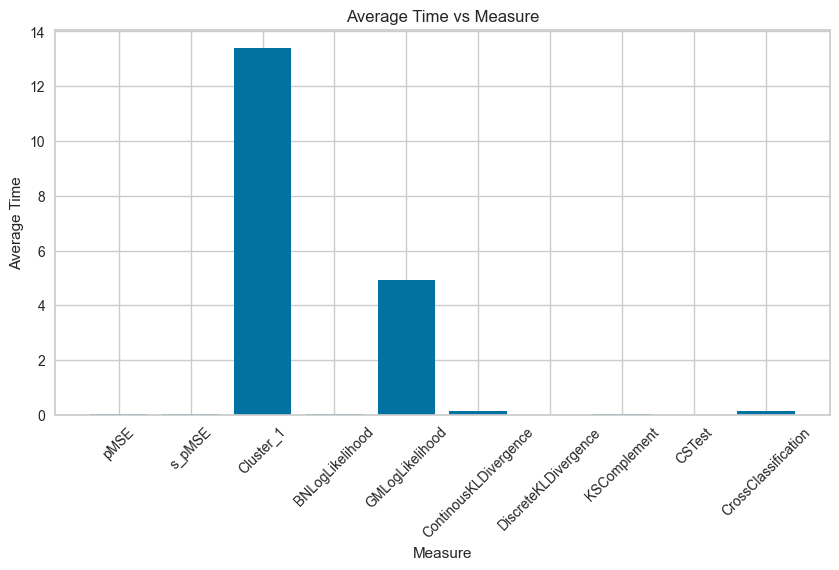

In [50]:
# Provided DataFrame
data = m_pf_df

# Columns with "_time" suffix
time_columns = ['pMSE_time', 's_pMSE_time', 'Cluster_1_time', 'BNLogLikelihood_time', 'GMLogLikelihood_time',
                'ContinousKLDivergence_time', 'DiscreteKLDivergence_time', 'KSComplement_time', 'CSTest_time',
                'CrossClassification_time']

# Calculate the mean of the columns
mean_times = data[time_columns].mean()

# Prepare the data for the bar plot
bar_data = pd.DataFrame({'measure': [col[:-5] for col in time_columns], 'mean_time': mean_times.values})

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(bar_data['measure'], bar_data['mean_time'])
plt.xlabel('Measure')
plt.ylabel('Average Time')
plt.title('Average Time vs Measure')
plt.xticks(rotation=45)
plt.show()

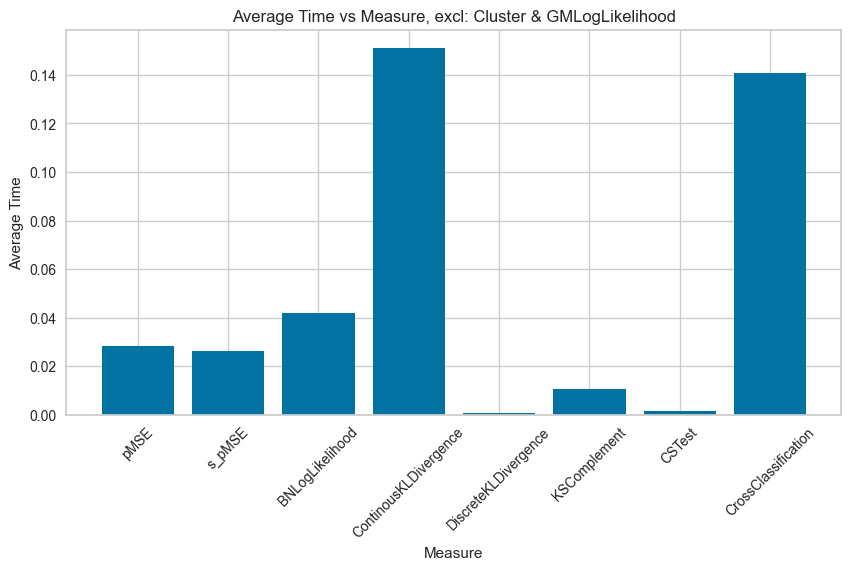

In [52]:
# Provided DataFrame
data = m_pf_df

# Columns with "_time" suffix
time_columns = ['pMSE_time', 's_pMSE_time', 'BNLogLikelihood_time',
                'ContinousKLDivergence_time', 'DiscreteKLDivergence_time', 'KSComplement_time', 'CSTest_time',
                'CrossClassification_time']

# Calculate the mean of the columns
mean_times = data[time_columns].mean()

# Prepare the data for the bar plot
bar_data = pd.DataFrame({'measure': [col[:-5] for col in time_columns], 'mean_time': mean_times.values})

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(bar_data['measure'], bar_data['mean_time'])
plt.xlabel('Measure')
plt.ylabel('Average Time')
plt.title('Average Time vs Measure, excl: Cluster & GMLogLikelihood')
plt.xticks(rotation=45)
plt.show()